In [ ]:
#!pip install -q transformers datasets evaluate

In [ ]:
#!pip install ipywidgets
#!pip install huggingface_hub
#!pip install matplotlib
#!pip install opencv-python
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install lightning

### Login into huggingface

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# GPU Config

### Check for free gpu to use for parallel computing

In [1]:
import subprocess

# Run nvidia-smi command
result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

Mon Apr  1 13:31:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000                On | 00000000:01:00.0 Off |                    0 |
| 35%   64C    P2               75W / 230W|   4405MiB / 23028MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### The Dataset is created by cropping the original images and labels into a size of (640x640). These crop images are then split into train test and val respectively based on ratio of (0.6, 0.2 and 0.2) respectively.

# Data Augmentation

In [2]:
#pip install -U albumentations

In [3]:
import albumentations as A

In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.filenames = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if not f.startswith('.')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx] + '.jpg')
        mask_path = os.path.join(self.masks_dir, self.filenames[idx] + '.png') 
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") 
        batch={"pixel_values": image, 
               "labels": mask
              }
        if self.transform:
            batch = self.transform(batch)
            for k,v in batch.items():
                batch[k].squeeze_() # remove batch dimension
                v[v==255]=1
                
        return batch

In [5]:
images_dir = "metalchip_dataset/images/train"
masks_dir = "metalchip_dataset/labels/train"
train_ds = ImageSegmentationDataset(images_dir, masks_dir)

In [6]:
image=train_ds[5]['pixel_values']
label=train_ds[5]['labels']

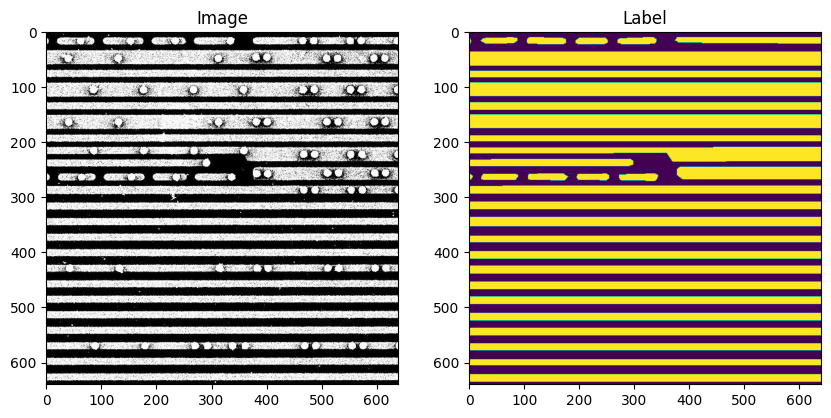

In [7]:
import matplotlib.pyplot as plt

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Label')
plt.imshow(label)

plt.show()

In [ ]:
import numpy as np

np_image = np.array(image)
np_label = np.array(label)

In [ ]:
# Define the transformation
HFlip = A.Compose([
    A.HorizontalFlip(p=1),  
])
# Define the transformation
VFlip = A.Compose([
    A.VerticalFlip(p=1),  
])
CJ = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.7, hue=0.2, p=1),
])

## Horizontal Flip

In [ ]:
import matplotlib.pyplot as plt

# Apply the transformation
transformed = HFlip(image=np_image)
transformed_image = transformed["image"]

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np_image)

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(transformed_image)

plt.show()

## Vertical Flip

In [ ]:
import matplotlib.pyplot as plt

# Apply the transformation
transformed = VFlip(image=np_image)
transformed_image = transformed["image"]

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np_image)

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(transformed_image)

plt.show()

## ColorJitter 

In [ ]:
import matplotlib.pyplot as plt

# Apply the transformation
transformed = CJ(image=np_image)
transformed_image = transformed["image"]

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np_image)

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(transformed_image)

plt.show()

# Load Dataset

### Create dataset dict with the images and labels

### The Dataset dict is created by passing in the image directory as well as the labels directory. Images are in jpg format while the labels are in png format. The dictionary entries can be accessed by indexing e.g. dataset[idx]. The images and labels are converted to arrays. The label's pixel_values are also converted from 255 to 1 in order to match the output from argmax from the model's prediction later. For each dictionary entries, there are two elements.
### To access image, dataset[idx][0]. 
### To access label, dataset[idx][1].
### Transformation is also defined so that we can normalize both the images and labels and resize the image. ImageNet mean = (0.485, 0.456, 0.406) and std = (0.229, 0.224, 0.225) are used for the normalization. Since DinoV2 is a vision transformer that uses patch size=14, we have to resize the images and labels to a size closest to a multiple of 14 which is 644.

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader 
import torch

class ImageSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.filenames = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if not f.startswith('.')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx] + '.jpg')
        mask_path = os.path.join(self.masks_dir, self.filenames[idx] + '.png') 
        image = Image.open(img_path).convert("RGB")
        np_image=np.array(image)
        mask = Image.open(mask_path) 
        np_mask=np.array(mask)
        np_mask[np_mask==255]=1
        
        transformed = self.transform(image=np_image, mask=np_mask)
        image, target = torch.tensor(transformed['image']), torch.LongTensor(transformed['mask'])
        
        # convert to C, H, W
        image = image.permute(2,0,1)
        
                
        return image, target, np_image, np_mask

### Define Transformation

In [3]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

normalization= A.Compose([
    A.Resize(width=644, height=644),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# Defining Data Module from pytorch lightning

### Defining Data Module as Dinov2 takes in an image that is a tensor of size (batch_size, num_channels, height, width).
### collate_fn is used to group images and labels together for each batch instead of each batch containing an image and label.

In [4]:
def collate_fn(inputs):
    batch = dict()
    batch["pixel_values"] = torch.stack([i[0] for i in inputs], dim=0) 
    batch["labels"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["original_images"] = [i[2] for i in inputs]
    batch["original_segmentation_maps"] = [i[3] for i in inputs]

    return batch

In [5]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, dataset_dir, batch_size, num_workers):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = ImageSegmentationDataset(images_dir=os.path.join(self.dataset_dir, 'images', 'train'),
                                                          masks_dir=os.path.join(self.dataset_dir, 'labels', 'train'),
                                                          transform=normalization) # Add your transforms here
            self.val_dataset = ImageSegmentationDataset(images_dir=os.path.join(self.dataset_dir, 'images', 'val'),
                                                        masks_dir=os.path.join(self.dataset_dir, 'labels', 'val'),
                                                        transform=normalization) # Add your transforms here
        if stage == 'test' or stage is None:
            self.test_dataset = ImageSegmentationDataset(images_dir=os.path.join(self.dataset_dir, 'images', 'test'),
                                                         masks_dir=os.path.join(self.dataset_dir, 'labels', 'test'),
                                                         transform=normalization) # Add your transforms here
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=collate_fn)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=collate_fn)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=collate_fn)

In [6]:
batch_size=1
num_workers=4

data_module = SegmentationDataModule(dataset_dir='data_augmentation_dataset', batch_size=batch_size, num_workers=num_workers)

### Check dataloader has the proper config for DinoV2 

In [7]:
data_module.setup(stage='fit')
train_dataloader = data_module.train_dataloader()

In [8]:
batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 644, 644])
labels torch.Size([1, 644, 644])
original_images (640, 640, 3)
original_segmentation_maps (640, 640)


### Creating id for the class

In [9]:
newid2label={
    0: 'Background',
    1: 'Metal Lines'
}
newid2label

{0: 'Background', 1: 'Metal Lines'}

In [10]:
newlabel2id = {v: k for k, v in newid2label.items()}
newlabel2id

{'Background': 0, 'Metal Lines': 1}

In [11]:
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from torchmetrics import Metric
from datasets import load_metric
from torch import nn
import numpy as np
import random
import torch
torch.set_float32_matmul_precision("medium")
import evaluate
from torch.nn.functional import interpolate
from torch.nn import CrossEntropyLoss

## Defining Pytorch Lightning Module

### Next, we define the model, which consists of DINOv2 as backbone + a linear classifier on top. DINOv2 is a regular vision transformer, hence it outputs "patch embeddings", meaning an embedding vector for each image patch. Since we use an image resolution of 644 pixels, and we use a DINOv2 model that has a patch resolution of 14, we get (644/14)**2 = 2116 patches out. So the model outputs a tensor of shape (batch_size, number of patches, hidden_size) = (batch_size, 2116, 768) for a batch of images (the model has a hidden size - also called embedding dimension - of 768).

### Next, we reshape this tensor to become (batch_size, 46, 46, 768), after which we apply the linear layer (below implemented as a Conv2D layer - which is equivalent to a linear transformation when you employ a kernel size of 1x1). This conv2D layer converts the patch embeddings into a logits tensor of shape (batch_size, num_labels, height, width) - which is what we need for semantic segmentation. This tensor contains scores as predicted by the model for all of the classes, for each pixel, for every example in the batch.

In [12]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=46, tokenH=46, num_labels=1):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)
        
class Dinov2Finetuner(pl.LightningModule):
    def __init__(self, id2label):
        super(Dinov2Finetuner, self).__init__()
        self.id2label = id2label
        self.num_classes = len(id2label.keys())
        self.model = Dinov2Model.from_pretrained(
            "facebook/dinov2-base",
            id2label=self.id2label,
            num_labels=self.num_classes
        )
         # Freeze dinov2 parameters
        for name, param in self.model.named_parameters():
            if name.startswith("dinov2"):
                param.requires_grad = False
                
        self.classifier = LinearClassifier(self.model.config.hidden_size, 46, 46, self.model.config.num_labels)
        
        evaluate.load
        self.train_mean_iou = evaluate.load("mean_iou")
        self.val_mean_iou = evaluate.load("mean_iou")
        self.test_mean_iou = evaluate.load("mean_iou")

    def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
    # use frozen features
        outputs = self.model(pixel_values,
                                output_hidden_states=output_hidden_states,
                                output_attentions=output_attentions)
        # get the patch embeddings - so we exclude the CLS token
        patch_embeddings = outputs.last_hidden_state[:,1:,:]
        
        # convert to logits and upsample to the size of the pixel values
        logits = self.classifier(patch_embeddings)
        logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)
        
        loss = None
        if labels is not None:
          loss_fct = torch.nn.CrossEntropyLoss()
          loss = loss_fct(logits, labels)
        
        return SemanticSegmenterOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
        
    def training_step(self, batch, batch_idx):
        outputs = self(
            pixel_values=batch["pixel_values"],
            labels=batch["labels"],
        )
        loss = outputs.loss
        self.log("loss", loss, sync_dist=True, batch_size=batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(
            pixel_values=batch["pixel_values"],
            labels= batch["labels"],
        )
        loss = outputs.loss
        self.log("loss", loss, sync_dist=True, batch_size=batch_size)
        return loss
        
    def test_step(self, batch, batch_idx):
        outputs = self(
            pixel_values=batch["pixel_values"],
            labels=batch["labels"],
        )
        loss = outputs.loss
        self.log("loss", loss, sync_dist=True, batch_size=batch_size)
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=0.0001)

# Initialising Model (base model: "vitb14")

### Load previously trained model

In [13]:
path="dinov2_checkpoint_hyperparameters-10epocs.ckpt"
model = Dinov2Finetuner.load_from_checkpoint(path,id2label=newid2label)

## Training the model

### Training, Val and test is done using python instead

# Test model performance

In [14]:
model.eval()

Dinov2Finetuner(
  (model): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
       

### Function to get the respective batch by index

In [15]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model.to(device)

Dinov2Finetuner(
  (model): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
       

In [16]:
data_module.setup(stage='test')
test_dataloader = data_module.test_dataloader()

In [17]:
len(test_dataloader)

576

In [18]:
def getBatch(index):
    data_module.setup(stage='test')
    test_dataloader = data_module.test_dataloader()
    test_iterator = iter(test_dataloader)
    for i in range(index):
        batch = next(test_iterator)
    return batch

In [28]:
batch=getBatch(460)

### Function to view mask

### Function to do predictions for a batch

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def viewMask(batch):
    # Plot expects (height, width, channels), hence transpose.
    image=batch["original_images"][0]
    label=batch["original_segmentation_maps"][0]
    
    
    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)
    axs[0].set_title("Image", {'fontsize': 40})
    axs[0].imshow(image)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(label)

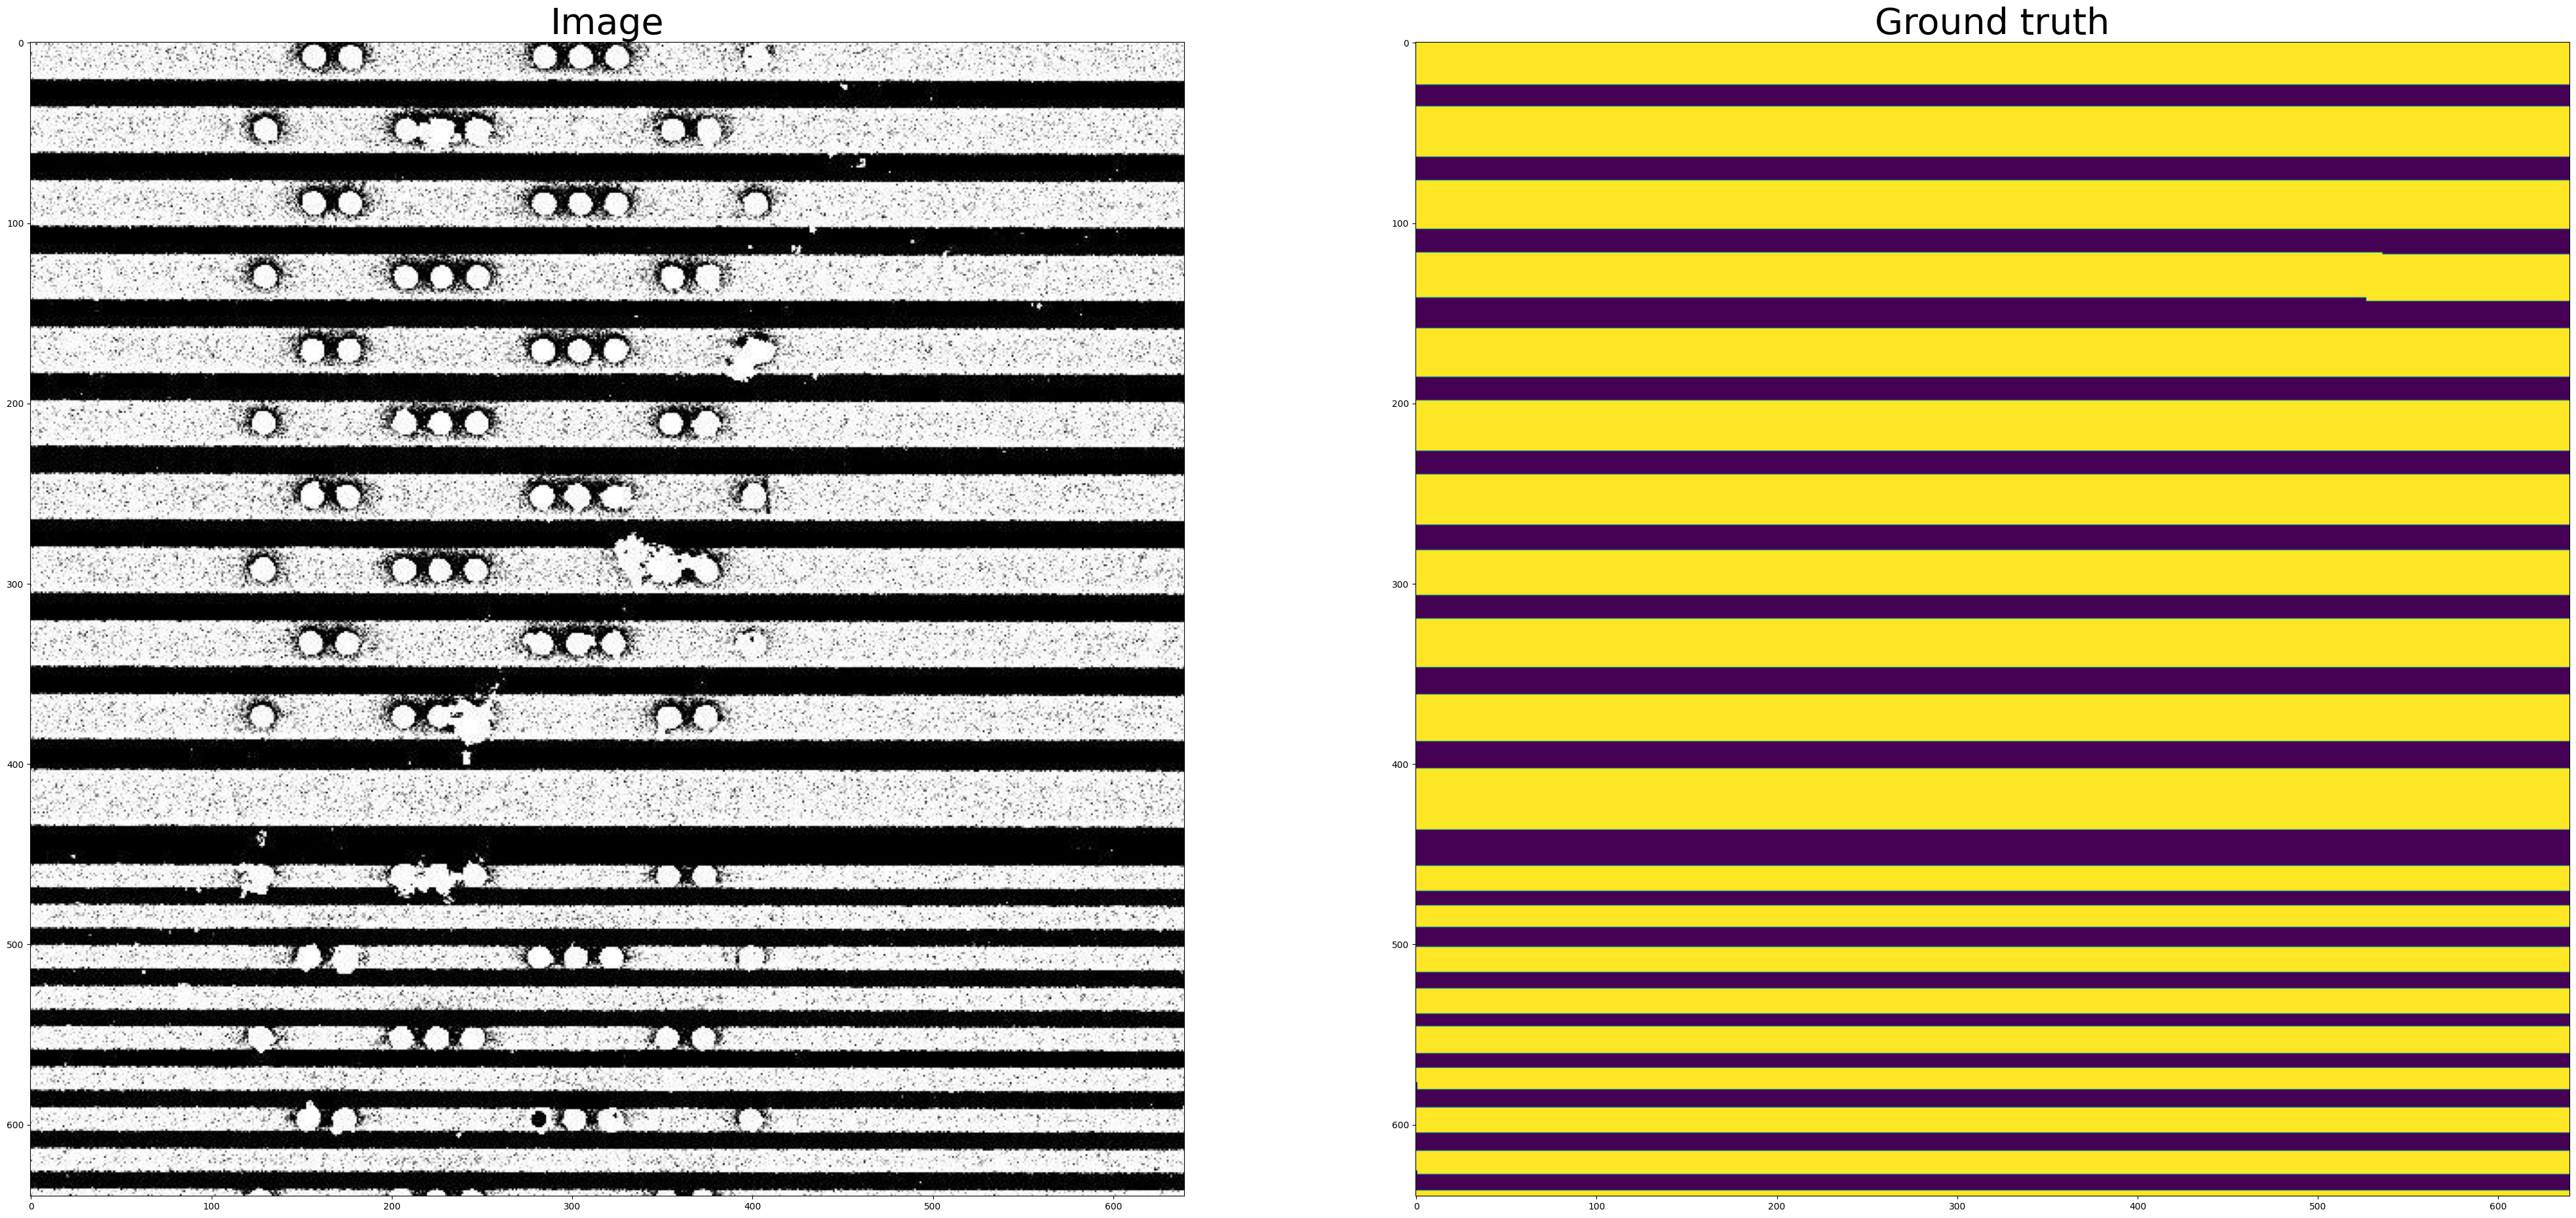

In [30]:
viewMask(batch)

In [31]:
#Batch size=1
def batch_prediction(batch):
    original_images = batch["original_images"]
    #target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        labels= batch["labels"].to(device),
      )
    downsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=[640,640],
                                                   mode="bilinear", align_corners=False)
    predicted_map = downsampled_logits.argmax(dim=1)
    results=predicted_map.squeeze().detach().cpu().numpy()
    original_segmentation_maps = batch["original_segmentation_maps"][0]
    return results, original_segmentation_maps

In [32]:
pred_semantic_map,label=batch_prediction(batch)

In [33]:
def viewPrediction(prediction,label):
    # Need to convert image and labels to numpy to plot. 
    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)
    axs[0].set_title("Prediction", {'fontsize': 40})
    axs[0].imshow(prediction)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(label)

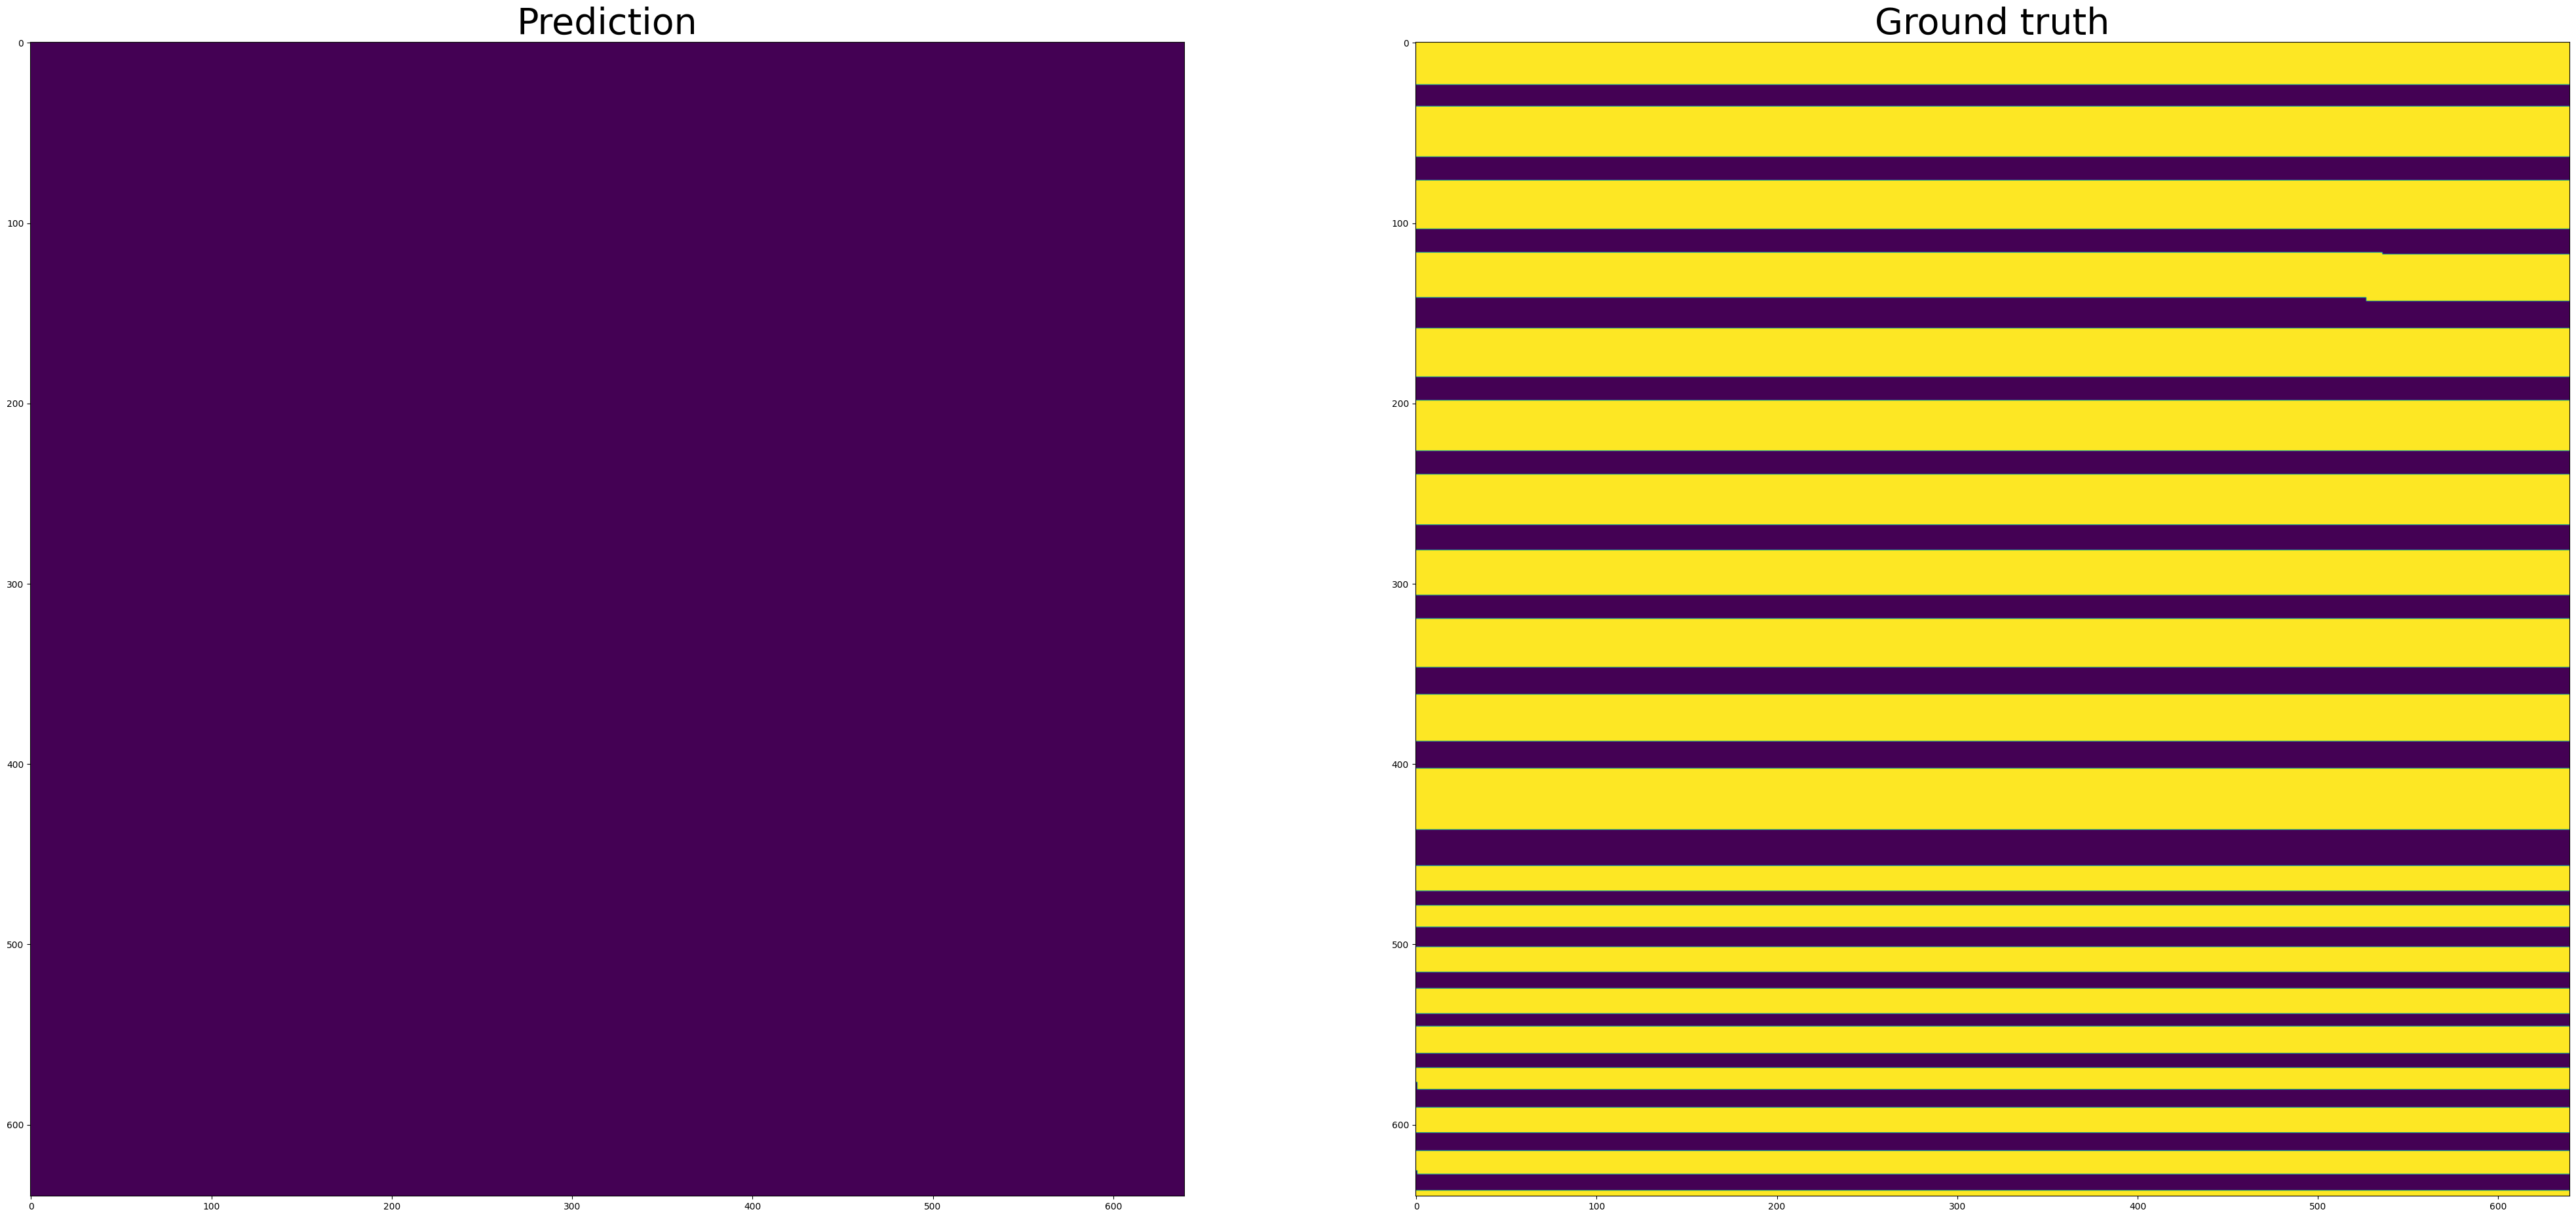

In [34]:
viewPrediction(pred_semantic_map,label)

### Define a function to display a prediction overlay in which blue represents correct prediction while red represent in correct prediction

In [35]:
def wrongPredictionOverlay(image,label):
    matches = image == label
    # Create an array highlighting wrong predictions: 0 for correct predictions, 2 for mismatches
    wrong_predictions = np.where(matches, 0, image)
    wrong_predictions[wrong_predictions==1]=2
    array_3d_colored = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    color_map = {
        0:(0,0,0),
        1:(0,128,128),
        2:(255,0,0)
        }
    for id, color in color_map.items():
        array_3d_colored[image == id] = color
        array_3d_colored[wrong_predictions == id] = color
    
    # Display the original and transformed images
    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)
    axs[0].set_title("Prediction overlay", {'fontsize': 40})
    axs[0].imshow(array_3d_colored)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(label)

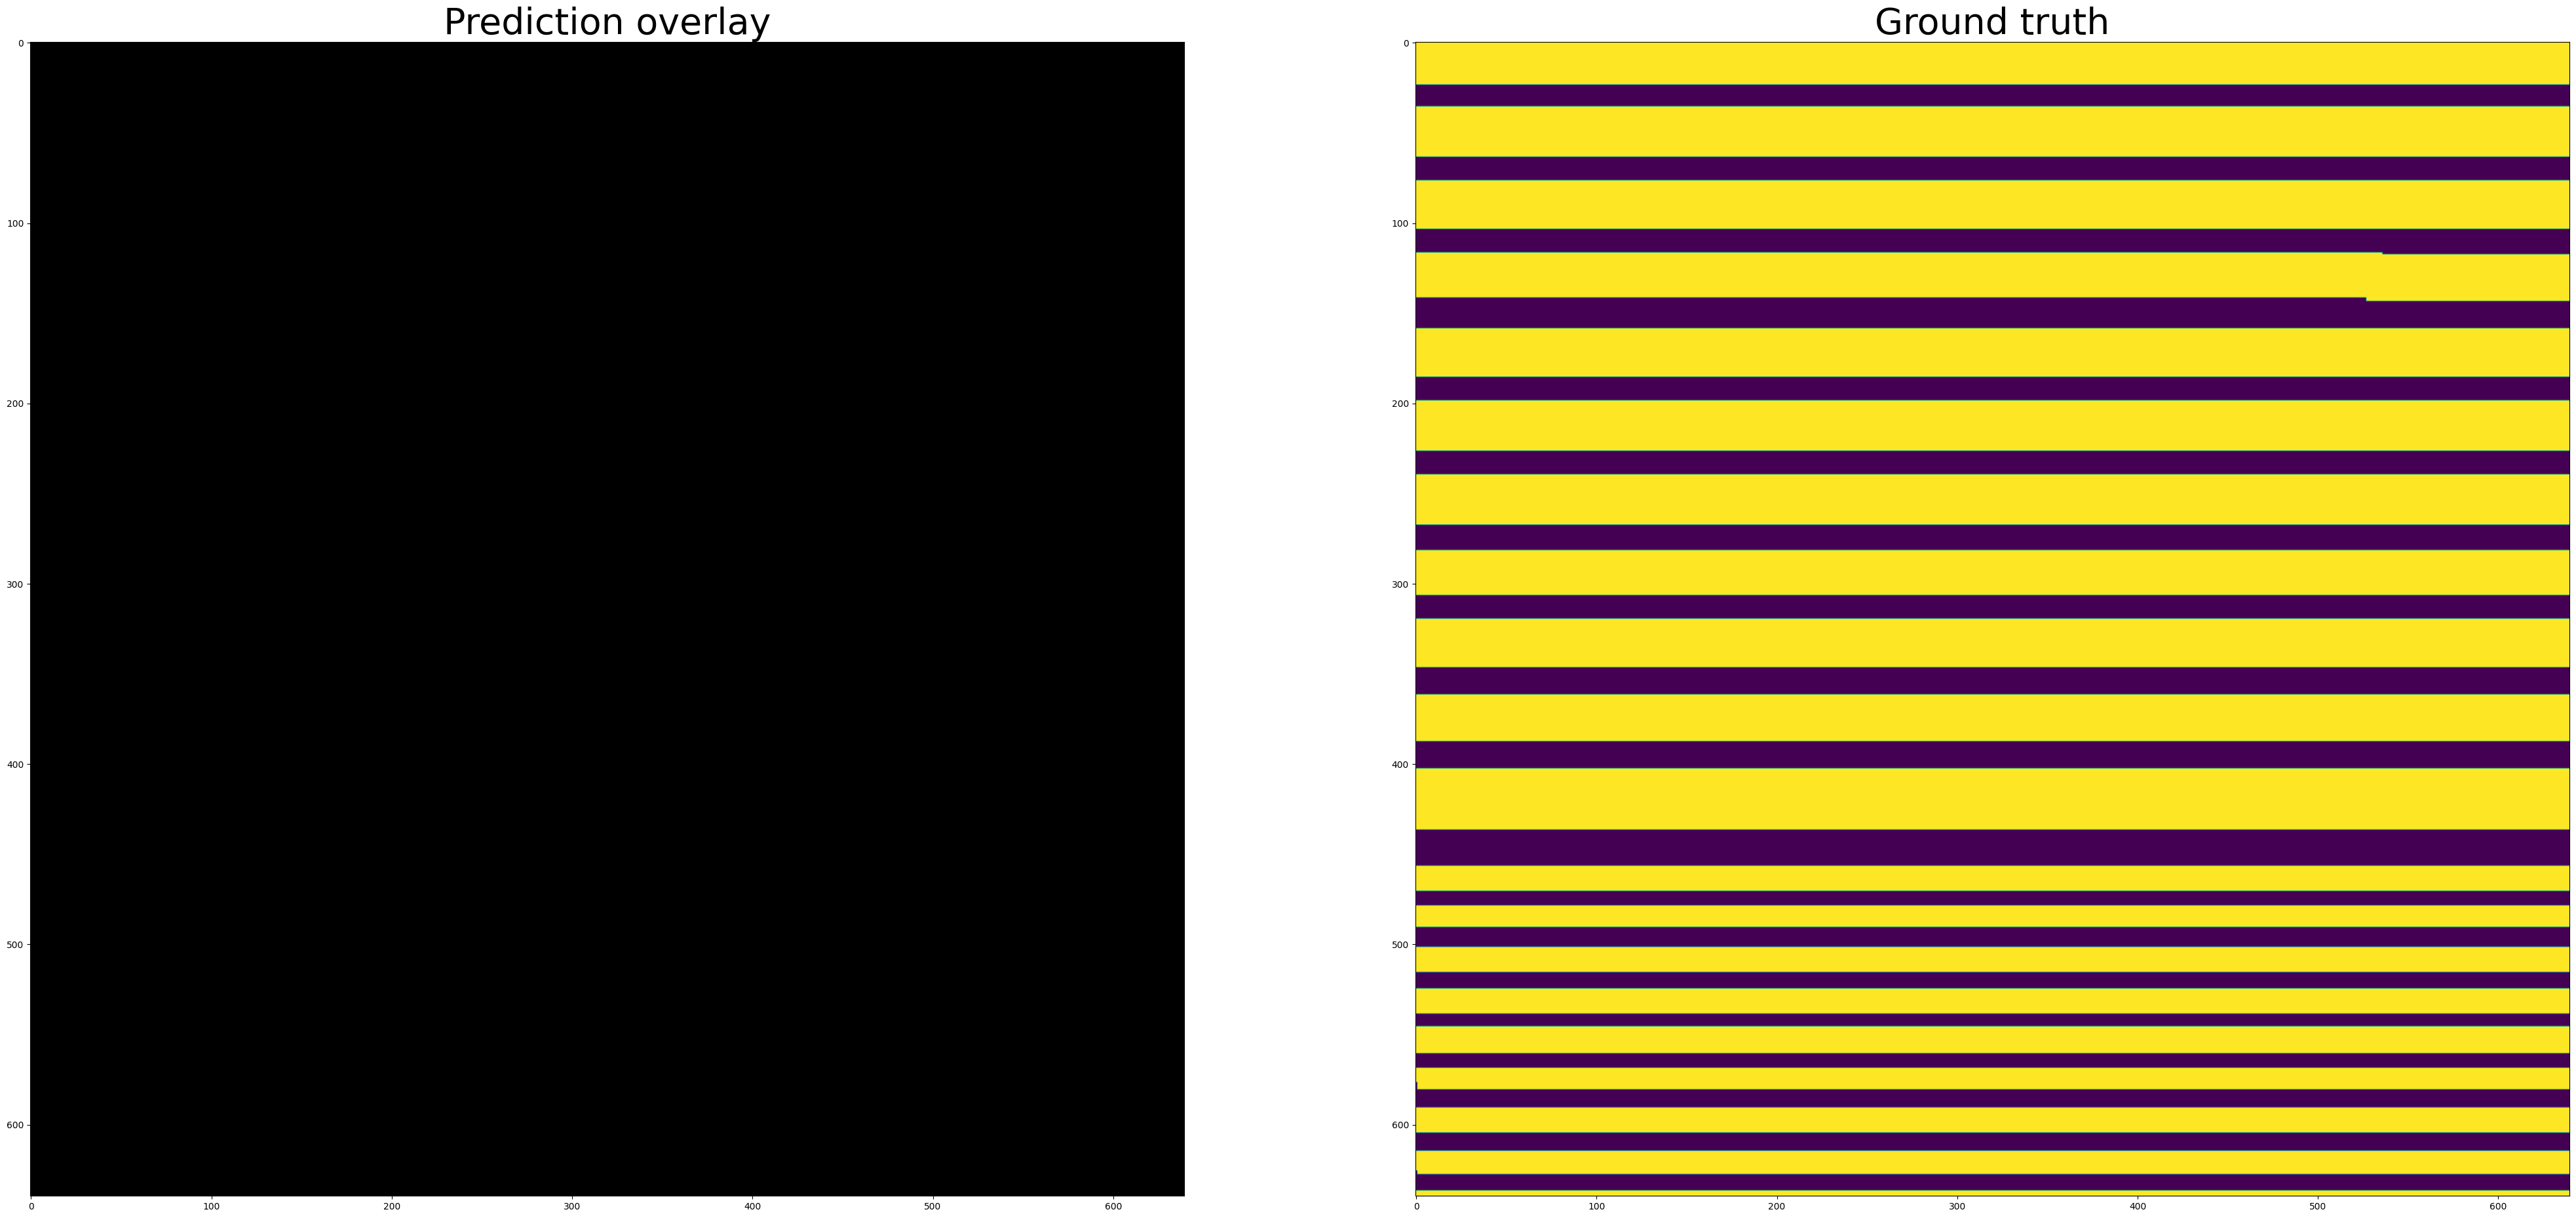

In [36]:
wrongPredictionOverlay(pred_semantic_map,label)

### Function to compute Miou for single image

In [37]:
def miou(pred,label):
    metric = evaluate.load("mean_iou")
    # Now your data should match the expected format:
    metrics = metric._compute(
        predictions=pred,
        references=label,
        num_labels=len(newid2label),
        ignore_index=254
    )
      # add per category metrics as individual key-value pairs
    # Extract per category metrics and convert to list if necessary (pop before defining the metrics dictionary)
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    # Re-define metrics dict to include per-category metrics directly
    metrics = {
        "mean_iou": metrics["mean_iou"], 
        "mean_accuracy": metrics["mean_accuracy"],
        **{f"accuracy_{newid2label[i]}": v for i, v in enumerate(per_category_accuracy)},
        **{f"iou_{newid2label[i]}": v for i, v in enumerate(per_category_iou)}
    }
    
    return metrics

In [38]:
miou(pred_semantic_map,label)

{'mean_iou': 0.1795458984375,
 'mean_accuracy': 0.5,
 'accuracy_Background': 1.0,
 'accuracy_Metal Lines': 0.0,
 'iou_Background': 0.359091796875,
 'iou_Metal Lines': 0.0}

### Function to sort all the predictions of the dataset into list

In [30]:
def dataset_prediction(test_dataloader):
    result_list=[]
    original_seg_maps_list=[]
    for batch in test_dataloader:
        original_images = batch["original_images"]
        target_sizes = [(image.shape[1], image.shape[2]) for image in original_images]
        outputs = model(
              pixel_values=batch["pixel_values"].to(device),
              mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
              class_labels=[labels.to(device) for labels in batch["class_labels"]],
          )
        result = processor.post_process_semantic_segmentation(outputs,target_sizes=target_sizes)[0]
        result=result.cpu().numpy()
        result_list.append(result)
        original_seg_maps_list.append(batch['original_segmentation_maps'][0])
    return result_list, original_seg_maps_list

In [31]:
result_list, original_seg_maps_list=dataset_prediction(test_dataloader)

### Function to compute mean-Iou for test dataset

In [32]:
def dateset_miou(result_list, original_seg_maps_list):
    metric = evaluate.load("mean_iou")
    # Now your data should match the expected format:
    metrics = metric._compute(
        predictions=result_list,
        references=original_seg_maps_list,
        num_labels=len(newid2label),
        ignore_index=254
    )
      # add per category metrics as individual key-value pairs
    # Extract per category metrics and convert to list if necessary (pop before defining the metrics dictionary)
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()
    
    # Re-define metrics dict to include per-category metrics directly
    metrics = {
        "mean_iou": metrics["mean_iou"], 
        "mean_accuracy": metrics["mean_accuracy"],
        **{f"accuracy_{newid2label[i]}": v for i, v in enumerate(per_category_accuracy)},
        **{f"iou_{newid2label[i]}": v for i, v in enumerate(per_category_iou)}
    }
    return metrics

In [33]:
dateset_miou(result_list, original_seg_maps_list)

{'mean_iou': 0.9598818524597084,
 'mean_accuracy': 0.9794750109933109,
 'accuracy_Background': 0.9771732844663699,
 'accuracy_Metal Lines': 0.981776737520252,
 'iou_Background': 0.9567891886349561,
 'iou_Metal Lines': 0.9629745162844607}

In [ ]:
    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)
    axs[0].set_title("Image", {'fontsize': 40})
    axs[0].imshow(image_transpose)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(label)

### Function to save all the predictions 

In [43]:
from matplotlib import pyplot as plt
def savePredictions(result_list, original_seg_maps_list, save_path):
    for i in range(len(result_list)):
        file_name = f"result_{i}"
        # Set up the plot
        f, axs = plt.subplots(1, 2)
        f.set_figheight(30)
        f.set_figwidth(50)
        
        axs[0].set_title("Prediction", {'fontsize': 40})
        axs[0].imshow(result_list[i])
        axs[1].set_title("Ground truth", {'fontsize': 40})
        axs[1].imshow(original_seg_maps_list[i])
    
        # Construct the full path where the image will be saved
        file_path = os.path.join(save_path, f"{file_name}.png")
    
        # Save the figure
        plt.savefig(file_path, bbox_inches='tight')
        plt.close(f)  # Close the figure to free memory
    print("Predictions saved")

In [44]:
save_path='data_augmentation_dataset/outputs-mask2former/'
savePredictions(result_list, original_seg_maps_list,save_path)

Predictions saved
